# IT Ticket Classifier — DHAUZ Challenge

Notebook executável: carrega o dataset, amostra 200 tickets, monta o RAG (embeddings + FAISS), executa o fluxo LangGraph em exemplos e na amostra, calcula métricas.
Arquitetura baseada em pesquisa com experimentação em "labs/architecture-comparison.ipynb"

### Resultados do labs (architecture-comparison)

Gráfico de threshold KNN (cruzamento coverage × F1 macro) e tabela comparativa de modelos no conjunto de teste (hold-out excl. sample_200).

![KNN: métricas vs confidence threshold](charts/threshold.png)
Resultado mostra que threshold para maior coverage e maio f1 macro é 0.45
Cruzamento (coverage ≈ F1 macro): threshold=0.45 → coverage=90.35%, F1 macro=0.8697, accuracy=0.8680
Melhor equilíbrio (max coverage×F1): threshold=0.35 → coverage=95.31%, F1 macro=0.8450, accuracy=0.8424

**Tabela comparativa (test set):**

| model    | accuracy | f1_macro | f1_weighted |
|----------|----------|----------|-------------|
| RNN      | 0.772571 | 0.763023 | 0.773050    |
| LSTM     | 0.800138 | 0.794236 | 0.801268    |
| BiLSTM   | 0.831840 | 0.835082 | 0.832611    |
| BiGRU    | 0.833218 | 0.838499 | 0.833300    |
| CNN+BiGRU| 0.837354 | 0.842469 | 0.837848    |
| KNN      | 0.833218 | 0.832331 | 0.832036    |

### usaremos KNN pelo motivo de ser mais explicável e permitir construir uma base de conhecimento muito granular, veja mais em labs/architecture-comparison.ipynb

In [1]:
import os
import sys
import numpy as np
from pathlib import Path

ROOT = Path(".").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from dotenv import load_dotenv
load_dotenv(ROOT / ".env")

import config
np.random.seed(config.SEED)

## 0. Baixar dataset do Kaggle (só se ainda não tiver o CSV em data/raw)

In [2]:
from src.prep import download_from_kaggle

path = download_from_kaggle()
print(f"Dataset em: {path}")

Dataset em: /Users/moises/Documents/ticket-classifier/data/raw/all_tickets_processed_improved_v3.csv


## 1. Dataset completo → vector store; sample_200 → test set

In [3]:
import pandas as pd
from src.prep import document_text, load_dataset, get_text_and_label_columns, stratified_sample
from src.rag import VectorStore

df_full = load_dataset()
text_cols, label_col = get_text_and_label_columns(df_full)
classes = sorted(set(df_full[label_col].astype(str)))

n_sample = min(config.SAMPLE_SIZE, len(df_full))
df_sample = stratified_sample(df_full, label_col, n=n_sample)
df_sample.to_csv(config.DATA_PROCESSED / "sample_200.csv", index=False)
ids_test = set(df_sample["id"])
df_train = df_full[~df_full["id"].isin(ids_test)]

texts_train = [document_text(row, text_cols) for _, row in df_train.iterrows()]
labels_train = df_train[label_col].astype(str).tolist()
ids_train = df_train["id"].tolist()

artifact_path = config.ARTIFACTS_DIR
if (artifact_path / "index.faiss").exists():
    store = VectorStore.load(artifact_path)
    print("Vector store carregado de:", artifact_path)
else:
    vc = VectorStore()
    store = vc.build(texts_train, labels_train, ids=ids_train)
    store.save(artifact_path)
    print("Vector store construído (apenas train) e salvo em:", artifact_path)

texts = [document_text(row, text_cols) for _, row in df_sample.iterrows()]

print("Classes:", classes)
print("Vector store (train): %d documentos" % len(df_train))
print("Test set (sample_200): %d tickets" % len(df_sample))

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Vector store carregado de: /Users/moises/Documents/ticket-classifier/outputs/artifacts
Classes: ['Access', 'Administrative rights', 'HR Support', 'Hardware', 'Internal Project', 'Miscellaneous', 'Purchase', 'Storage']
Vector store (train): 47637 documentos
Test set (sample_200): 200 tickets


## 1.1 Estatísticas: dataset completo e sample_200

Dataset completo: 47837 tickets | 8 classes
Sample 200: 200 tickets (estratificado)



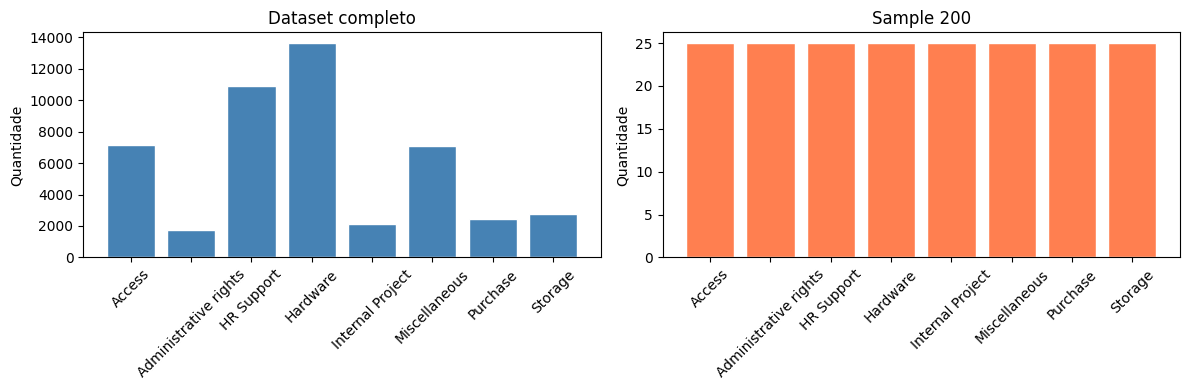

In [4]:
import matplotlib.pyplot as plt

print("Dataset completo:", len(df_full), "tickets |", len(classes), "classes")
print("Sample 200:", len(df_sample), "tickets (estratificado)")
print()

count_full = df_full[label_col].astype(str).value_counts().sort_index()
count_sample = df_sample[label_col].astype(str).value_counts().reindex(count_full.index, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(count_full.index, count_full.values, color="steelblue", edgecolor="white")
axes[0].set_title("Dataset completo")
axes[0].set_ylabel("Quantidade")
axes[0].tick_params(axis="x", rotation=45)

axes[1].bar(count_sample.index, count_sample.values, color="coral", edgecolor="white")
axes[1].set_title("Sample 200")
axes[1].set_ylabel("Quantidade")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

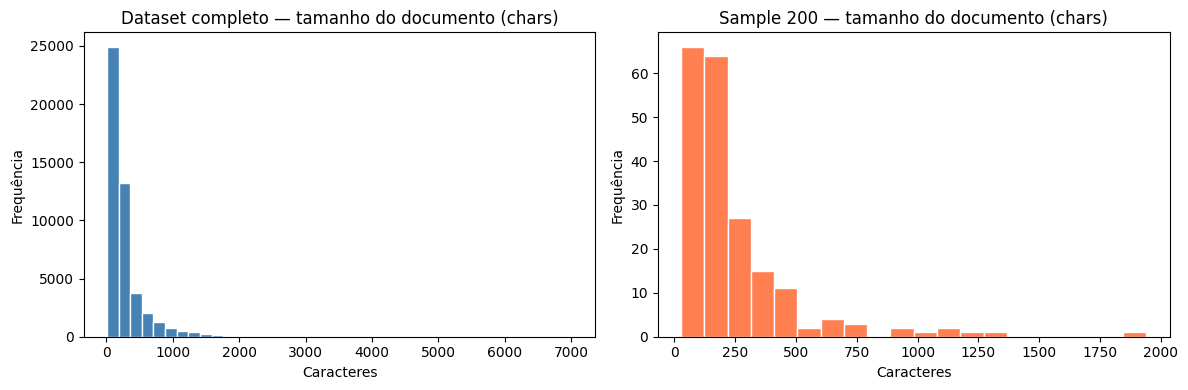

Dataset completo: min=7, max=7015, mediana=175 chars
Sample 200: min=29, max=1940, mediana=170 chars


In [5]:
doc_len_full = df_full[text_cols[0]].fillna("").astype(str).str.len()
doc_len_sample = df_sample[text_cols[0]].fillna("").astype(str).str.len()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(doc_len_full, bins=40, color="steelblue", edgecolor="white")
axes[0].set_title("Dataset completo — tamanho do documento (chars)")
axes[0].set_xlabel("Caracteres")
axes[0].set_ylabel("Frequência")

axes[1].hist(doc_len_sample, bins=20, color="coral", edgecolor="white")
axes[1].set_title("Sample 200 — tamanho do documento (chars)")
axes[1].set_xlabel("Caracteres")
axes[1].set_ylabel("Frequência")

plt.tight_layout()
plt.show()
print("Dataset completo: min=%d, max=%d, mediana=%.0f chars" % (doc_len_full.min(), doc_len_full.max(), doc_len_full.median()))
print("Sample 200: min=%d, max=%d, mediana=%.0f chars" % (doc_len_sample.min(), doc_len_sample.max(), doc_len_sample.median()))

## 2. Inferência em exemplos


In [6]:
# store, classes e texts já carregados na célula 1.
import logging
from tqdm.auto import tqdm
from src.graph import build_pipeline, run_pipeline

logging.getLogger("ticket_classifier.llm_usage").setLevel(logging.WARNING)

compiled, _, _ = build_pipeline(store)

for i in tqdm(range(min(3, len(texts))), desc="Exemplos"):
    out = run_pipeline(compiled, texts[i], classes)
    print(f"--- Ticket {i+1} ---")
    print("Texto (trecho):", texts[i][:150], "...")
    print("Saída:", out)
    print()

Exemplos:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
{"step": "knn_classify", "event": "classification", "classe": "Hardware", "confidence": 1.0}
llama_context: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_set_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_c4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4          

--- Ticket 1 ---
Texto (trecho): monitor request vulcan friday october pm hello please log each user monitor allocation user vulcan thank weekend engineer friday october vulcan parte  ...
Saída: {'classe': 'Hardware', 'justificativa': "Os termos 'monitor', 'vulcan', 'request', 'allocation' e 'log' correlacionam com a classe 'Hardware' pois mencionam a gestão de recursos de hardware. Além disso, os vizinhos KNN também mencionam 'monitor' e 'allocation', o que reforça a correlação com a classe 'Hardware'.", 'classification_source': 'knn', 'confidence': 1.0, 'inference_time_sec': 21.952257584000108, 'classification_tokens': None, 'justification_tokens': 486}



{"step": "knn_classify", "event": "classification", "classe": "Hardware", "confidence": 0.5714}
{"step": "agent_justify", "event": "justification", "input_tokens": 339, "output_tokens": 99, "total_tokens": 438}
{"step": "inference", "event": "inference", "classification_source": "knn", "classe": "Hardware", "inference_time_sec": 14.2444, "justification_tokens": 438}
{"step": "knn_classify", "event": "classification", "classe": "Hardware", "confidence": 1.0}


--- Ticket 2 ---
Texto (trecho): stopped when docker start was executed sent wednesday february hi we having same problem we had few days ago server was stopped when executed docker s ...
Saída: {'classe': 'Hardware', 'justificativa': "O termo 'server stopped' é comum em todos os vizinhos e no próprio ticket, indicando que a classe atribuída 'Hardware' está relacionada a problemas de acesso ao servidor. Além disso, a menção a 'docker' e 'machine' nos vizinhos #0 e #3, e no próprio ticket, sugere que a classe está relacionada a problemas de execução de containers Docker.", 'classification_source': 'knn', 'confidence': 0.5714285714285714, 'inference_time_sec': 14.244432583000162, 'classification_tokens': None, 'justification_tokens': 438}



{"step": "agent_justify", "event": "justification", "input_tokens": 402, "output_tokens": 121, "total_tokens": 523}
{"step": "inference", "event": "inference", "classification_source": "knn", "classe": "Hardware", "inference_time_sec": 16.9304, "justification_tokens": 523}


--- Ticket 3 ---
Texto (trecho): issue re access through for hello still work attached log error received during installation restarted machine disconnected tethered phone can connect ...
Saída: {'classe': 'Hardware', 'justificativa': "Os termos 're access through for hello still work attached log error received during installation restarted machine disconnected tethered phone can connect' correlacionam com a classe 'Hardware' pois mencionam problemas de conexão e instalação, que são comuns em problemas de hardware. Além disso, os vizinhos KNN (#0, #1, #2, #3, #4, #5 e #6) também mencionam problemas de conexão e instalação, o que reforça a classificação de 'Hardware'.", 'classification_source': 'knn', 'confidence': 1.0, 'inference_time_sec': 16.930405916999916, 'classification_tokens': None, 'justification_tokens': 523}



## 3. Rodar na amostra de 200 e salvar resultados

In [7]:
import logging
import time
from src.logging_utils import log_result
from tqdm.auto import tqdm

logging.getLogger("ticket_classifier.llm_usage").setLevel(logging.WARNING)

results_path = config.OUTPUTS / "results_sample.jsonl"
if results_path.exists():
    results_path.unlink()

max_tickets = None
it = list(df_sample.iterrows())
if max_tickets is not None:
    it = it[:max_tickets]

predictions = []
t0 = time.perf_counter()
for pos, (_, row) in enumerate(tqdm(it, desc="Pipeline")):
    text = document_text(row, text_cols)
    out = run_pipeline(compiled, text, classes, instance_id=row["id"])
    pred = out["classe"]
    predictions.append(pred)
    log_result({
        "id": row["id"],
        "ticket_index": pos,
        "text": text,
        "true": row[label_col],
        "pred": pred,
        "justificativa": out["justificativa"],
        "classification_source": out.get("classification_source"),
        "confidence": out.get("confidence"),
        "inference_time_sec": out.get("inference_time_sec"),
        "classification_tokens": out.get("classification_tokens"),
        "justification_tokens": out.get("justification_tokens"),
    })
elapsed = time.perf_counter() - t0
n = len(predictions)
print(f"Salvos {n} resultados em {results_path}")
print(f"Tempo total: {elapsed:.1f}s | Média por ticket: {elapsed/n:.1f}s (gargalo: 1 chamada LLM por ticket)")

Pipeline:   0%|          | 0/200 [00:00<?, ?it/s]

Salvos 200 resultados em /Users/moises/Documents/ticket-classifier/outputs/results_sample.jsonl
Tempo total: 5341.9s | Média por ticket: 26.7s (gargalo: 1 chamada LLM por ticket)


## 4. Métricas e relatório

In [8]:
from src.metrics import compute_metrics, save_metrics_report

y_true = df_sample[label_col].astype(str).tolist()
metrics = compute_metrics(y_true, predictions, labels=classes)
save_metrics_report(metrics)

print("Accuracy:", metrics["accuracy"])
print("F1 macro:", metrics["f1_macro"])
print("F1 weighted:", metrics["f1_weighted"])
print("\nClassification report:")
for k, v in metrics["classification_report"].items():
    if isinstance(v, dict):
        print(k, v)
    else:
        print(k, v)

Accuracy: 0.82
F1 macro: 0.8192791700772786
F1 weighted: 0.8192791700772786

Classification report:
Access {'precision': 0.8214285714285714, 'recall': 0.92, 'f1-score': 0.8679245283018868, 'support': 25.0}
Administrative rights {'precision': 0.9285714285714286, 'recall': 0.52, 'f1-score': 0.6666666666666666, 'support': 25.0}
HR Support {'precision': 0.7777777777777778, 'recall': 0.84, 'f1-score': 0.8076923076923077, 'support': 25.0}
Hardware {'precision': 0.76, 'recall': 0.76, 'f1-score': 0.76, 'support': 25.0}
Internal Project {'precision': 0.95, 'recall': 0.76, 'f1-score': 0.8444444444444444, 'support': 25.0}
Miscellaneous {'precision': 0.6052631578947368, 'recall': 0.92, 'f1-score': 0.7301587301587301, 'support': 25.0}
Purchase {'precision': 0.9230769230769231, 'recall': 0.96, 'f1-score': 0.9411764705882353, 'support': 25.0}
Storage {'precision': 1.0, 'recall': 0.88, 'f1-score': 0.9361702127659575, 'support': 25.0}
accuracy 0.82
macro avg {'precision': 0.8457647323436797, 'recall': 

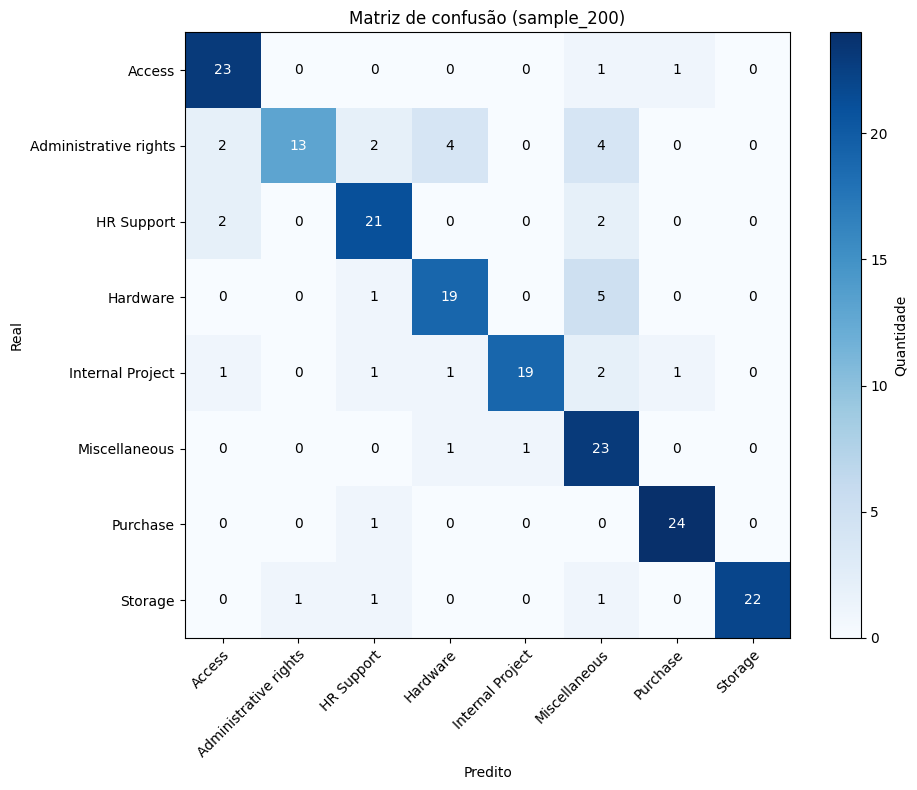

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, predictions, labels=classes)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
fig.colorbar(im, ax=ax, label="Quantidade")
ax.set_title("Matriz de confusão (sample_200)")
plt.tight_layout()
plt.show()

## 5. Exemplo de saída JSON

In [9]:
import json
ex = run_pipeline(compiled, texts[0], classes)
print(json.dumps(ex, indent=2, ensure_ascii=False))

{
  "classe": "Hardware",
  "justificativa": "Os termos 'monitor', 'vulcan' e 'log' correlacionam com a classe 'Hardware' pois mencionam equipamentos e ações relacionadas à manutenção e gerenciamento deles. Além disso, os vizinhos KNN também mencionam 'monitor' e 'log' em seus textos, o que reforça a correlação com a classe 'Hardware'.",
  "classification_source": "knn",
  "confidence": 1.0,
  "inference_time_sec": 15.265702665999925,
  "classification_tokens": null,
  "justification_tokens": 495
}


---